In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

trishalakarmacharya_kaggle_json_path = kagglehub.dataset_download('trishalakarmacharya/kaggle-json')
trishalakarmacharya_environment_path = kagglehub.dataset_download('trishalakarmacharya/environment')
trishalakarmacharya_bike_sharing_demand_path = kagglehub.dataset_download('trishalakarmacharya/bike-sharing-demand')

print('Data source import complete.')


# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

### Install packages

In [ ]:
!pip install -U pip
!pip install pandas
!pip install kaggle
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
!pip install unzip
# Without --no-cache-dir, smaller aws instances may have trouble installing
!pip install python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.0/804.0 kB 16.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.38.4
    Uninstalling wheel-0.38.4:
      Successfully uninstalled wheel-0.38.4
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.8.0
    Uninstalling setuptools-59.8.0:
      Successfully uninstalled setuptools-59.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-spanner 3.27.0 requires google-api-core[grpc]!=2.0.*,!=2.1.*,!=2.10.*,!=2.2.*,!=2.3.*,!=2.4.*,!

### Setup Kaggle API Key

In [ ]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
from dotenv import dotenv_values
CONFIG = dotenv_values('/kaggle/input/environment/.env')
kaggle_username = CONFIG['KAGGLE_USERNAME']
kaggle_key = CONFIG['KAGGLE_KEY']
# Save API token the kaggle.json file
with open("kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))


### Download and explore dataset

### Go to the [bike sharing demand competition](https://www.kaggle.com/c/bike-sharing-demand) and agree to the terms
![kaggle6.png](attachment:kaggle6.png)

In [ ]:
!mkdir -p ~/.kaggle
!cp /kaggle/input/kaggle-json/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list


ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rakeshkapilavai/extrovert-vs-introvert-behavior-data            Extrovert vs. Introvert Behavior Data               31KB  2025-06-13 14:26:48          18529        405  1.0              
bismasajjad/global-ai-job-market-and-salary-trends-2025         Global AI Job Market & Salary Trends 2025          517KB  2025-06-01 07:20:49           6843        111  0.9411765        
adilshamim8/social-media-addiction-vs-relationships             Students' Social Media Addiction                     8KB  2025-05-10 14:38:02          17808        271  1.0              
prajwaldongre/loan-application-and-transaction-fraud-detection  L

In [ ]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
import zipfile
with zipfile.ZipFile('bike-sharing-demand.zip','r') as z:
    z.extractall()

  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 52.3MB/s]


In [ ]:
!pip install autogluon.tabular --quiet


DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [ ]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [ ]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv',parse_dates = ['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [ ]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv',parse_dates = ['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv',parse_dates = ['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

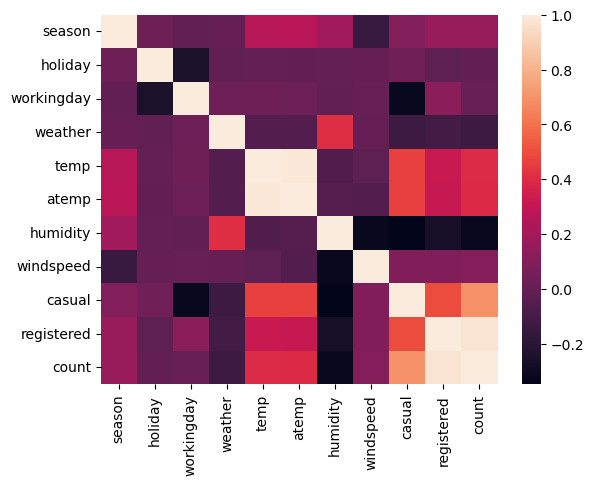

In [ ]:
sns.heatmap(train.corr());

## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset.
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
predictor = TabularPredictor(label='count',eval_metric = 'root_mean_squared_error',
                            learner_kwargs = {"ignored_columns": ["casual", "registered"]}).fit(train_data = train,
                                                                          time_limit =300,
                                                                          presets = 'best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20250616_160321/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20250616_160321/"
AutoGluon Version:  0.6.2
Python Version:     3.7.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regres

### Review AutoGluon's training run with ranking of models that did the best.

In [ ]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                   model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      LightGBMXT_BAG_L2  -60.774946      84.855869  271.904273               24.929981          84.181874            2       True          6
1    WeightedEnsemble_L3  -60.774946      84.856793  271.909829                0.000925           0.005555            3       True          7
2  KNeighborsDist_BAG_L1  -84.139994       0.054230    0.024892                0.054230           0.024892            1       True          2
3    WeightedEnsemble_L2  -84.139994       0.055197    0.378629                0.000967           0.353737            2       True          5
4  KNeighborsUnif_BAG_L1 -101.573722       0.056528    1.226576                0.056528           1.226576            1       True          1
5        LightGBM_BAG_L1 -131.054162      12.058094   58.968965               12.05809

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.57372218106647,
  'KNeighborsDist_BAG_L1': -84.13999364278118,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'WeightedEnsemble_L2': -84.13999364278118,
  'LightGBMXT_BAG_L2': -60.77494566213506,
  'WeightedEnsemble_L3': -60.77494566213506},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'KNeighborsUnif_BAG_L1': 'AutogluonModels/ag-20250616_160321/models/KNeighborsUnif_BAG_L1/',
  'KNeighborsDist_BAG_L1': 'AutogluonModels/ag-20250616_160321/models/KNeighborsDist_BAG_L1/',
  'LightGBMXT_BAG_L1': 'AutogluonModels/ag-202

<AxesSubplot:xlabel='model'>

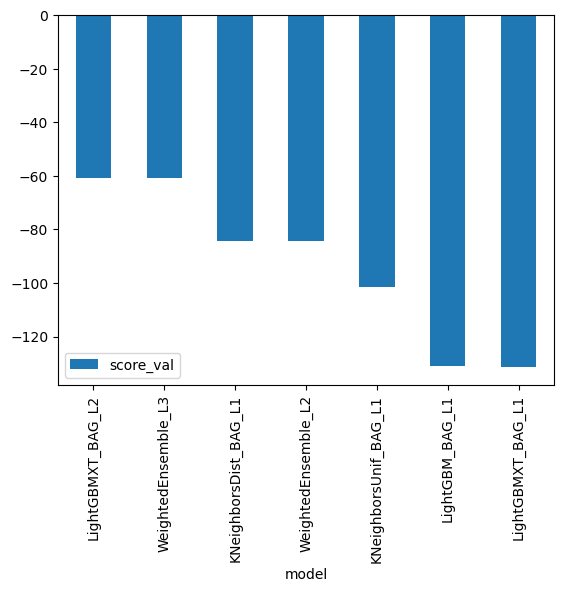

In [ ]:
predictor.leaderboard(silent = True).plot(kind = 'bar',x = 'model',y = 'score_val')

### Create predictions from test dataset

In [ ]:
predictor.get_model_names()

['KNeighborsUnif_BAG_L1',
 'KNeighborsDist_BAG_L1',
 'LightGBMXT_BAG_L1',
 'LightGBM_BAG_L1',
 'WeightedEnsemble_L2',
 'LightGBMXT_BAG_L2',
 'WeightedEnsemble_L3']

In [ ]:
predictions = predictor.predict(test)
predictions.head()

0    34.372520
1    42.365173
2    48.134609
3    52.555149
4    54.487957
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [ ]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      106.363449
std       101.880005
min        -4.437493
25%        15.039785
50%        62.662796
75%       187.099335
max       403.451935
Name: count, dtype: float64

In [ ]:
# How many negative values do we have?
predictions[predictions < 0].count()

84

In [ ]:
# Set them to zero
for a,b in enumerate(predictions):
    if b < 0:
        predictions[a] = 0

In [ ]:
predictions.describe()

count    6493.000000
mean      106.379745
std       101.862816
min         0.000000
25%        15.039785
50%        62.662796
75%       187.099335
max       403.451935
Name: count, dtype: float64

### Set predictions to submission dataframe, save, and submit

In [ ]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 290kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand
#| tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2025-06-16 16:11:17  first raw submission               complete  2.06498      2.06498       
submission_new_features.csv  2025-06-13 18:32:32  new features                       error                                
submission_new_hpo.csv       2025-06-12 15:46:55  new features with hyperparameters  complete  2.06084      2.06084       
submission_new_features.csv  2025-06-12 15:40:53  new features                       complete  1.84672      1.84672       
submission.csv               2025-06-12 15:32:14  first raw submission hp1           complete  1.41005      1.41005       
submission.csv               2025-06-12 15:24:00  first raw submission hp0           complete  1.41005      1.41005       
submission.csv  

#### Initial score of `1.84672`

### Using `XGBOOST` as the algorithm.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
predictor_hp0 = TabularPredictor(label='count',eval_metric = 'rmse').fit(train_data = pd.concat([train.iloc[:,:-3],train.iloc[:,-1]],axis = 1),
                                                                          time_limit =300,
                                                                          presets = 'best_quality',
                                                                    hyperparameters = {'XGB':{'learning_rate':0.1}})

No path specified. Models will be saved in: "AutogluonModels/ag-20250616_161131/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20250616_161131/"
AutoGluon Version:  0.6.2
Python Version:     3.7.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regress

In [ ]:
predictor_hp0.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       XGBoost_BAG_L2 -130.590563       8.014871  193.770850                5.766083         105.617150            2       True          3
1  WeightedEnsemble_L3 -130.590563       8.015826  193.776682                0.000956           0.005832            3       True          4
2       XGBoost_BAG_L1 -131.624665       2.248787   88.153700                2.248787          88.153700            1       True          1
3  WeightedEnsemble_L2 -131.624665       2.249693   88.163722                0.000906           0.010021            2       True          2
Number of models trained: 4
Types of models trained:
{'StackerEnsembleModel_XGBoost', 'WeightedEnsembleModel'}
Bagging used: True  (with 8 folds)
Multi-layer stack-ensembling used: True  (with 3 levels)
Feature Metadata (Processed):
(raw 

{'model_types': {'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'XGBoost_BAG_L1': -131.62466543942023,
  'WeightedEnsemble_L2': -131.62466543942023,
  'XGBoost_BAG_L2': -130.59056321268582,
  'WeightedEnsemble_L3': -130.59056321268582},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'XGBoost_BAG_L1': 'AutogluonModels/ag-20250616_161131/models/XGBoost_BAG_L1/',
  'WeightedEnsemble_L2': 'AutogluonModels/ag-20250616_161131/models/WeightedEnsemble_L2/',
  'XGBoost_BAG_L2': 'AutogluonModels/ag-20250616_161131/models/XGBoost_BAG_L2/',
  'WeightedEnsemble_L3': 'AutogluonModels/ag-20250616_161131/models/WeightedEnsemble_L3/'},
 'model_fit_times': {'XGBoost_BAG_L1': 88.15370011329651,
  'WeightedEnsemble_L2': 0.010021448135375977,
  'XGBoost_BAG_L2': 105.61714959144592,
  'WeightedEnsemble_L3': 0.00583243370056

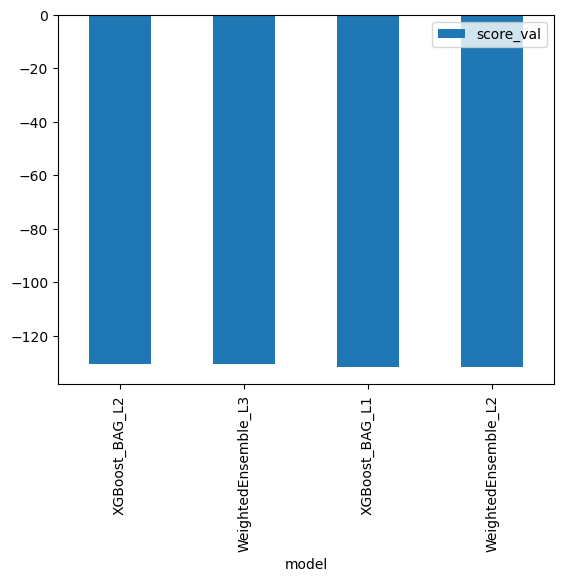

In [ ]:
#Displaying models which perform best.
predictor_hp0.leaderboard(silent = True).plot(kind = 'bar',x = 'model',y = 'score_val');

In [ ]:
#fitting model.
predictions_hp0 = predictor_hp0.predict(test,model = 'WeightedEnsemble_L2')
#making sure there is no negative value.
predictions_hp0.describe()


count    6493.000000
mean      206.521286
std       141.676361
min       -73.975266
25%        98.073288
50%       175.937088
75%       291.346222
max       771.201050
Name: count, dtype: float64

In [ ]:
# Set them to zero
for a,b in enumerate(predictions_hp0):
    if b < 0:
        predictions_hp0[a] = 0

In [ ]:
submission["count"] = predictions_hp0
submission.to_csv("submission.csv", index=False)


In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission hp0"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 292kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
#viewing kaggle score.
!kaggle competitions submissions -c bike-sharing-demand

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2025-06-16 16:16:20  first raw submission hp0           complete  1.41005      1.41005       
submission.csv               2025-06-16 16:11:17  first raw submission               complete  2.06498      2.06498       
submission_new_features.csv  2025-06-13 18:32:32  new features                       error                                
submission_new_hpo.csv       2025-06-12 15:46:55  new features with hyperparameters  complete  2.06084      2.06084       
submission_new_features.csv  2025-06-12 15:40:53  new features                       complete  1.84672      1.84672       
submission.csv               2025-06-12 15:32:14  first raw submission hp1           complete  1.41005      1.41005       
submission.csv  

#### Initial score of `2.06553`

### Using `GBM` as algorithm type

In [ ]:
import warnings
warnings.filterwarnings('ignore')
predictor_hp1 = TabularPredictor(label='count',eval_metric = 'rmse',
                                learner_kwargs = {"ignored_columns": ["casual", "registered"]}).fit(train_data = train,
                                                                          time_limit =300,
                                                                          presets = 'best_quality',hyperparameters = {'GBM':{'learning_rate':0.1}})

No path specified. Models will be saved in: "AutogluonModels/ag-20250616_161631/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20250616_161631/"
AutoGluon Version:  0.6.2
Python Version:     3.7.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regres

In [ ]:
predictor_hp1.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      LightGBM_BAG_L2 -129.461423       8.229146  177.717477                2.190549          78.716491            2       True          3
1  WeightedEnsemble_L3 -129.461423       8.229950  177.724318                0.000804           0.006842            3       True          4
2      LightGBM_BAG_L1 -129.587247       6.038597   99.000985                6.038597          99.000985            1       True          1
3  WeightedEnsemble_L2 -129.587247       6.039573   99.007684                0.000976           0.006698            2       True          2
Number of models trained: 4
Types of models trained:
{'StackerEnsembleModel_LGB', 'WeightedEnsembleModel'}
Bagging used: True  (with 8 folds)
Multi-layer stack-ensembling used: True  (with 3 levels)
Feature Metadata (Processed):
(raw dtyp

{'model_types': {'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM_BAG_L1': -129.58724666204176,
  'WeightedEnsemble_L2': -129.58724666204176,
  'LightGBM_BAG_L2': -129.46142312501328,
  'WeightedEnsemble_L3': -129.46142312501328},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'LightGBM_BAG_L1': 'AutogluonModels/ag-20250616_161631/models/LightGBM_BAG_L1/',
  'WeightedEnsemble_L2': 'AutogluonModels/ag-20250616_161631/models/WeightedEnsemble_L2/',
  'LightGBM_BAG_L2': 'AutogluonModels/ag-20250616_161631/models/LightGBM_BAG_L2/',
  'WeightedEnsemble_L3': 'AutogluonModels/ag-20250616_161631/models/WeightedEnsemble_L3/'},
 'model_fit_times': {'LightGBM_BAG_L1': 99.00098514556885,
  'WeightedEnsemble_L2': 0.0066983699798583984,
  'LightGBM_BAG_L2': 78.71649146080017,
  'WeightedEnsemble_L3': 0.006841659545

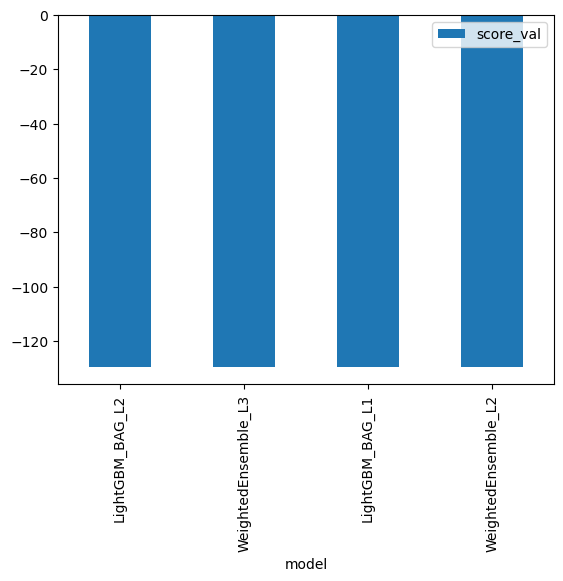

In [ ]:
#Displaying models which perform best.
predictor_hp1.leaderboard(silent = True).plot(kind = 'bar',x = 'model',y = 'score_val');

In [ ]:
#fitting model.
predictions_hp1 = predictor_hp1.predict(test,model = 'LightGBM_BAG_L1')
#making sure there is no negative value.
predictions_hp1.describe()

count    6493.000000
mean      196.080734
std       134.641190
min       -55.577496
25%        95.908310
50%       167.732056
75%       275.850647
max       753.400085
Name: count, dtype: float64

In [ ]:
# Set them to zero
for a,b in enumerate(predictions_hp1):
    if b < 0:
        predictions_hp1[a] = 0

In [ ]:
submission["count"] = predictions_hp1
submission.to_csv("submission.csv", index=False)


In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission hp1"

100%|█████████████████████████████████████████| 189k/189k [00:00<00:00, 295kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
#viewing kaggle score.
!kaggle competitions submissions -c bike-sharing-demand

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2025-06-16 16:21:14  first raw submission hp1           error                                
submission.csv               2025-06-16 16:16:20  first raw submission hp0           complete  1.41005      1.41005       
submission.csv               2025-06-16 16:11:17  first raw submission               complete  2.06498      2.06498       
submission_new_features.csv  2025-06-13 18:32:32  new features                       error                                
submission_new_hpo.csv       2025-06-12 15:46:55  new features with hyperparameters  complete  2.06084      2.06084       
submission_new_features.csv  2025-06-12 15:40:53  new features                       complete  1.84672      1.84672       
submission.csv  

#### Initial score `1.56074`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Generating feature histograms for EDA...


<Figure size 1500x1200 with 0 Axes>

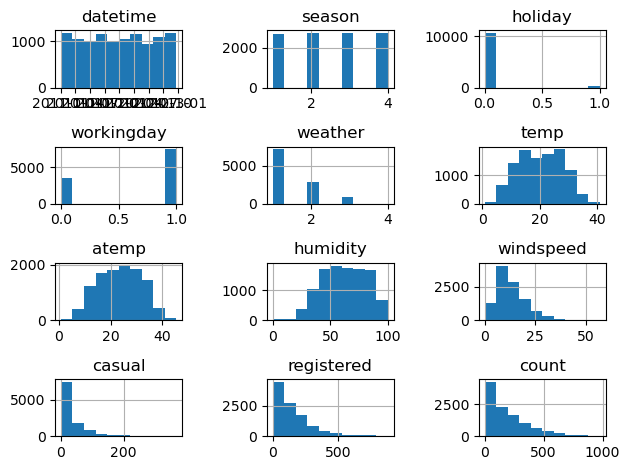

In [ ]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
print("\nGenerating feature histograms for EDA...")
plt.figure(figsize=(15, 12))
train.hist()
plt.tight_layout()
plt.show()

**NEW FEATURES**

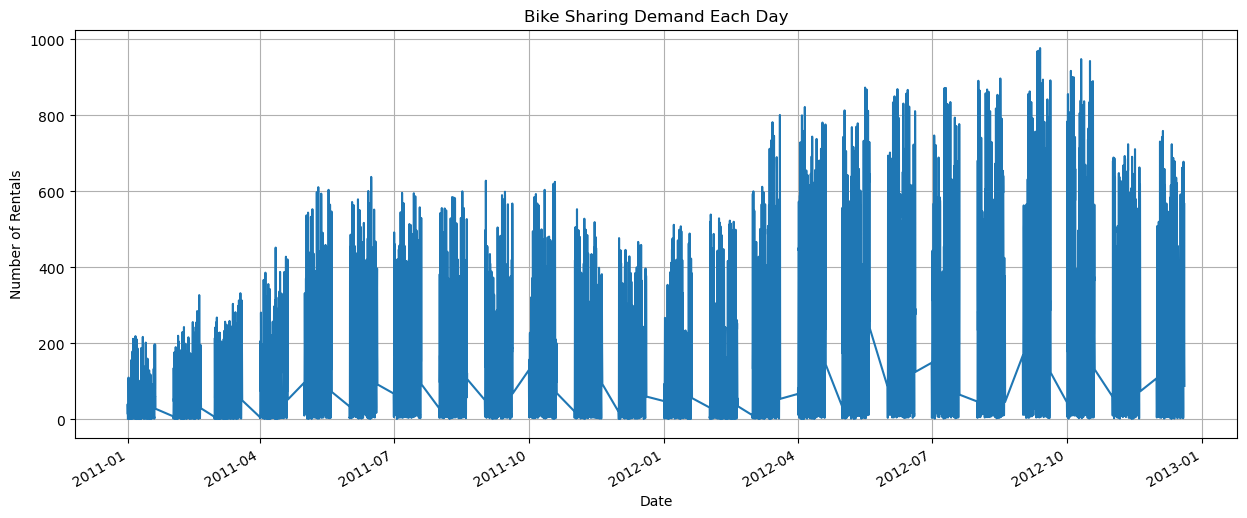

In [ ]:
# Number of rentals per day
plt.figure(figsize=(15, 6))
train.set_index('datetime')['count'].plot()
plt.title('Bike Sharing Demand Each Day')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

train = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv')
test = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')

# Convert datetime column
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])


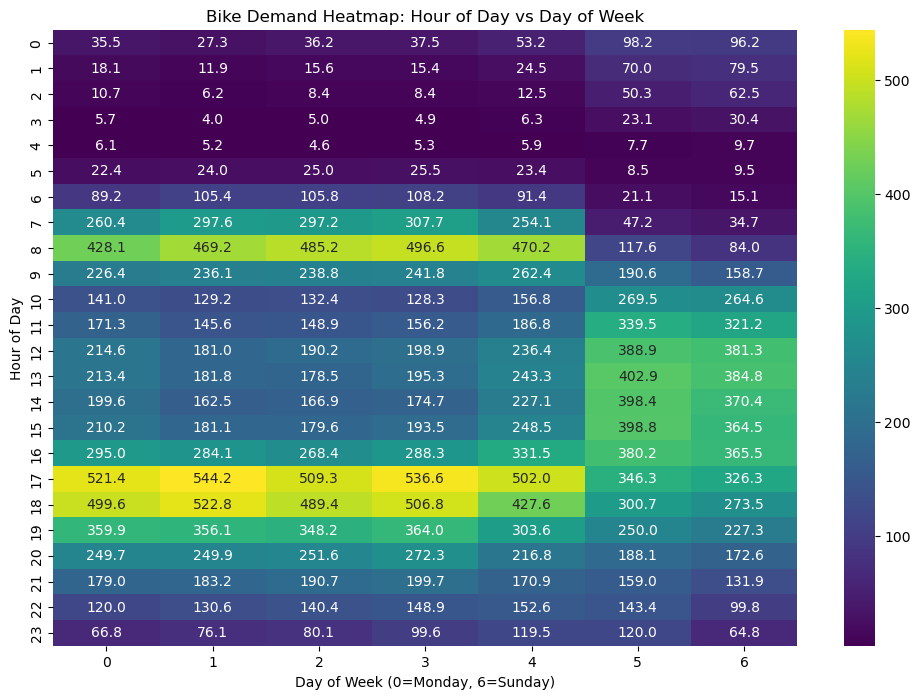

In [ ]:
#Hour of Day vs Day of Week
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
train = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv')
  # Adjust the path as necessary

# Convert 'datetime' column to datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

# Extract hour and day of week
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek

# Create a pivot table for the heatmap
hour_day_heatmap = train.pivot_table(
    index='hour',
    columns='dayofweek',
    values='count',  # Replace with the actual target column name
    aggfunc='mean'
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(hour_day_heatmap, cmap='viridis', annot=True, fmt='.1f')
plt.title('Bike Demand Heatmap: Hour of Day vs Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Hour of Day')
plt.show()


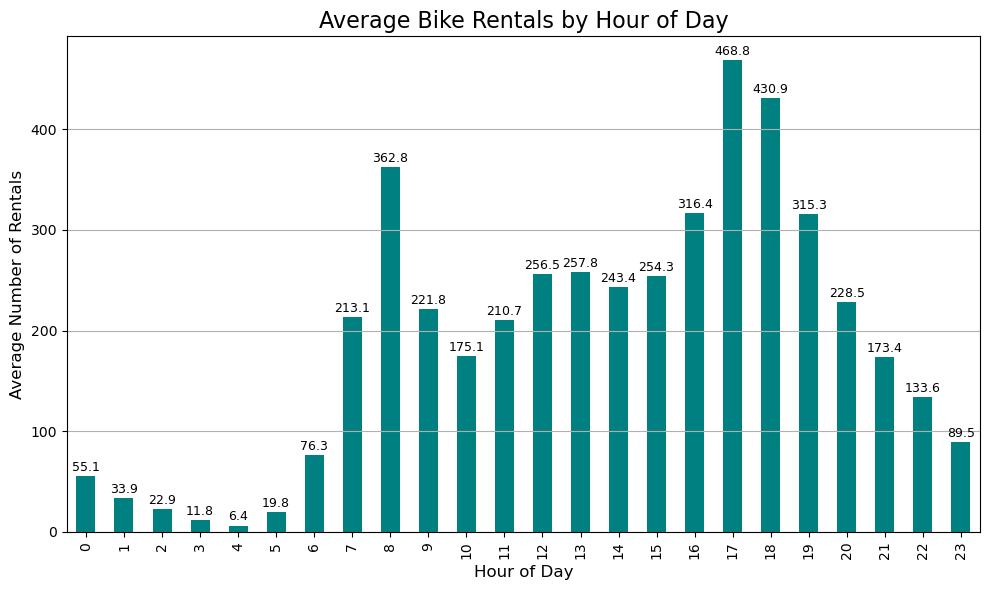

In [ ]:
#Average Bike Rentals by Hour of Day
# Create figure and axis
fig, ax2 = plt.subplots(figsize=(10, 6))

# Average demand by hour
hourly_avg = train.groupby(train['datetime'].dt.hour)['count'].mean()
hourly_avg.plot(kind='bar', ax=ax2, color='teal')

# Set labels and title
ax2.set_title('Average Bike Rentals by Hour of Day', fontsize=16)
ax2.set_xlabel('Hour of Day', fontsize=12)
ax2.set_ylabel('Average Number of Rentals', fontsize=12)
ax2.grid(True, axis='y')

# Add value labels above bars
for i, v in enumerate(hourly_avg):
    ax2.text(i, v + 5, f'{v:.1f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [ ]:
# Create new datetime-based features
print("\nExtracting datetime features...")
# Extract hour from datetime - this is likely an important predictor for bike demand
train['hour'] = train['datetime'].dt.hour
test['hour'] = test['datetime'].dt.hour

# Extract additional potentially useful datetime features
train['day'] = train['datetime'].dt.day
train['month'] = train['datetime'].dt.month
train['dayofweek'] = train['datetime'].dt.dayofweek
train['year'] = train['datetime'].dt.year

test['day'] = test['datetime'].dt.day
test['month'] = test['datetime'].dt.month
test['dayofweek'] = test['datetime'].dt.dayofweek
test['year'] = test['datetime'].dt.year


Extracting datetime features...


In [ ]:
# Set categorical features to the correct dtype
# This helps AutoGluon identify these as categorical variables rather than continuous
print("\nConverting categorical features to proper data types...")
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')
train["hour"] = train["hour"].astype('category')
train["month"] = train["month"].astype('category')
train["dayofweek"] = train["dayofweek"].astype('category')

test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')
test["hour"] = test["hour"].astype('category')
test["month"] = test["month"].astype('category')
test["dayofweek"] = test["dayofweek"].astype('category')


Converting categorical features to proper data types...


In [ ]:
# View the updated dataset
print("\nUpdated training data with new features:")
train.head()


Updated training data with new features:


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,dayofweek,day,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5,1,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1,1,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,5,1,1,2011
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,5,1,1,2011
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,5,1,1,2011



Generating updated feature histograms...


<Figure size 1500x1200 with 0 Axes>

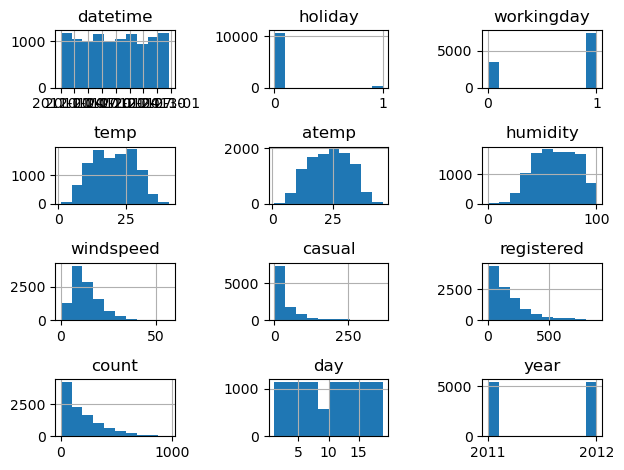

In [ ]:
# Generate histograms with new features to see their distributions
print("\nGenerating updated feature histograms...")
plt.figure(figsize=(15, 12))
train.hist()
plt.tight_layout()
plt.show()

Below from Template

In [ ]:
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')
test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')

In [ ]:
train.dtypes

datetime      datetime64[ns]
season              category
holiday                int64
workingday             int64
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
hour                category
dayofweek           category
day                    int64
month               category
year                   int64
dtype: object

In [ ]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,dayofweek,day,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5,1,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1,1,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,5,1,1,2011
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,5,1,1,2011
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,5,1,1,2011


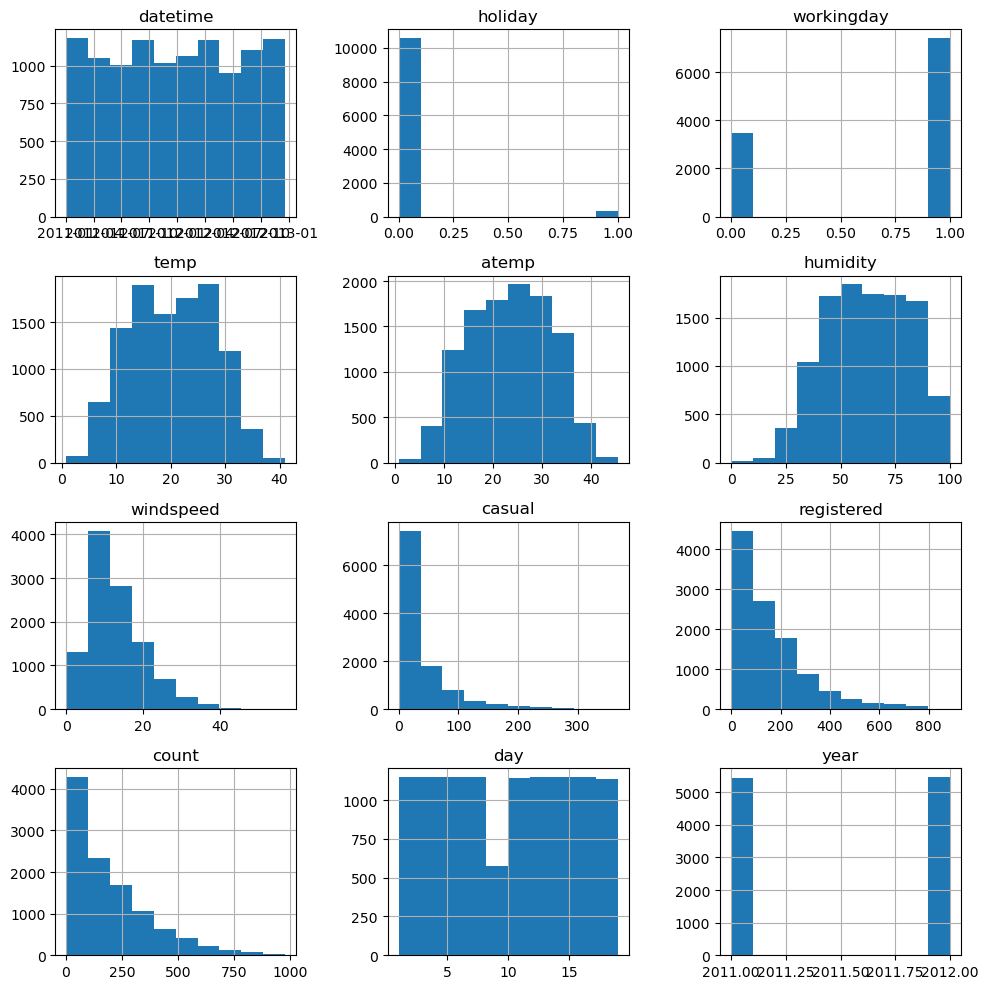

In [ ]:
train.hist(figsize = [10,10])
plt.tight_layout()
plt.show()

## Step 5: Rerun the model with the same settings as before, just with more features

In [ ]:
# Define columns to exclude from training - same as before
exclude_columns_enhanced = ['casual', 'registered', 'datetime']

In [ ]:
!pip install autogluon


In [ ]:
from autogluon.tabular import TabularPredictor

# Train a new model with the enhanced feature set
print("\nTraining model with enhanced features...")
predictor_new_features = TabularPredictor(
    label='count',
    eval_metric='root_mean_squared_error',
    path='models/ag_models_enhanced'
).fit(
    train_data=train.drop(exclude_columns_enhanced, axis=1),
    time_limit=600,
    presets='best_quality'
)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "models/ag_models_enhanced/"
AutoGluon Version:  0.6.2
Python Version:     3.7.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGe


Training model with enhanced features...


	13 features in original data used to generate 13 features in processed data.
	Train Data (Processed) Memory Usage: 0.53 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 0.18s ...
AutoGluon will gauge predictive performance using evaluation metric: 'root_mean_squared_error'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	To change this, specify the eval_metric parameter of Predictor()
AutoGluon will fit 2 stack levels (L1 to L2) ...
Fitting 11 L1 models ...
Fitting model: KNeighborsUnif_BAG_L1 ... Training model for up to 399.78s of the 599.81s of remaining time.
	-158.9155	 = Validation score   (-root_mean_squared_error)
	0.03s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: KNeighborsDist_BAG_L1 ... Training model for up to 399.64s of the 599.68s of remaining time.
	-162.7378	 = Validation score   (-root_mean_squared_error)
	0.03s	 = Trainin

In [ ]:
# Review the model training summary
print("\nEnhanced model training summary:")
predictor_new_features.fit_summary()


Enhanced model training summary:
*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2  -34.048647      52.666773  195.641226                0.001009           0.436509            2       True          7
1      WeightedEnsemble_L3  -34.427321      61.448808  513.771962                0.000978           0.365591            3       True         12
2          LightGBM_BAG_L2  -34.647904      57.760886  386.473448                3.723547          41.757662            2       True          9
3        LightGBMXT_BAG_L1  -34.770129      30.780114  101.422489               30.780114         101.422489            1       True          3
4   RandomForestMSE_BAG_L2  -35.216391      54.770710  387.799978                0.733371          43.084192            2       True         10
5        LightGBMXT_BAG_L2  -35.471603  

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -158.91552231156888,
  'KNeighborsDist_BAG_L1': -162.737768284632,
  'LightGBMXT_BAG_L1': -34.77012937123052,
  'LightGBM_BAG_L1': -35.97210082374322,
  'RandomForestMSE_BAG_L1': -38.921713427989935,
  'CatBoost_BAG_L1': -42.15419365431957,
  'WeightedEnsemble_L2': -34.04864668670487,
  'LightGBMXT_BAG_L2':

In [ ]:
# Generate predictions on the test set
print("\nGenerating predictions with enhanced model...")
predictions_new_features = predictor_new_features.predict(test.drop(['datetime'], axis=1))
print("Preview of enhanced predictions:")
print(predictions_new_features.head())


Generating predictions with enhanced model...
Preview of enhanced predictions:
0    15.072573
1     3.991802
2     2.880972
3     3.136190
4     2.827018
Name: count, dtype: float32


In [ ]:
# Handle negative predictions
negative_count_new = (predictions_new_features < 0).sum()
print(f"Number of negative predictions: {negative_count_new}")
predictions_new_features = predictions_new_features.clip(lower=0)
print("After clipping, minimum prediction value:", predictions_new_features.min())

Number of negative predictions: 112
After clipping, minimum prediction value: 0.0


In [ ]:
import pandas as pd

submission = pd.read_csv('/kaggle/input/bike-sharing-demand/sampleSubmission.csv')

In [ ]:
# Assuming predictor_new_features is your trained AutoGluon model and test is your test dataset
predictions = predictor_new_features.predict(test)

# Load submission file
submission = pd.read_csv('/kaggle/input/bike-sharing-demand/sampleSubmission.csv')

# Copy and assign predictions
submission_new_features = submission.copy()
submission_new_features["count"] = predictions

# Save the submission file
submission_new_features.to_csv("submission_new_features.csv", index=False)


In [ ]:
submission_new_features.to_csv("submission_new_features.csv", index=False)


In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 294kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2025-06-16 16:44:12  new features                       error                                
submission.csv               2025-06-16 16:21:14  first raw submission hp1           error                                
submission.csv               2025-06-16 16:16:20  first raw submission hp0           complete  1.41005      1.41005       


FROM TEMPLATE

In [ ]:
import warnings
warnings.filterwarnings('ignore')
predictor_new_features = TabularPredictor(label = 'count',eval_metric = 'root_mean_squared_error',
                                         learner_kwargs = {"ignored_columns": ["casual", "registered"]}).fit(train_data=train,
                                                                          time_limit =400,
                                                                    presets = 'best_quality')

In [ ]:
predictor_new_features.fit_summary()

In [ ]:
# Remember to set all negative values to zero
a = predictor_new_features.predict(test,model = 'WeightedEnsemble_L2')
a.describe()

In [ ]:
# Set them to zero
for i,b in enumerate(a):
    if b < 0:
        a[i] = 0
a.describe()

In [ ]:
# Same submitting predictions
submission_new_features = submission.copy()
submission_new_features["count"] = a
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [ ]:
!mkdir -p ~/.kaggle
!cp /kaggle/input/kaggle-json/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand
#| tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2025-06-16 16:44:12  new features                       error                                
submission.csv               2025-06-16 16:21:14  first raw submission hp1           error                                
submission.csv               2025-06-16 16:16:20  first raw submission hp0           complete  1.41005      1.41005       
submission.csv               2025-06-16 16:11:17  first raw submission               complete  2.06498      2.06498       
submission_new_features.csv  2025-06-13 18:32:32  new features                       error                                
submission_new_hpo.csv       2025-06-12 15:46:55  new features with hyperparameters  complete  2.06084      2.06084       
submission_new_f

#### New Score of `1.84672`

In [ ]:
predictor_new_features.leaderboard(silent = True).plot(kind = 'barh',x = 'model',y = 'score_val')

In [ ]:
predictor_new_features.get_model_names()

In [ ]:
predictor_new_features.get_model_best()

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
predictor_new_hpo = TabularPredictor(label = 'count',eval_metric = 'accuracy',
                                    problem_type = 'multiclass',
                                    learner_kwargs = {"ignored_columns": ["casual", "registered"]}).fit(train_data = train,
                                                                          time_limit =320,presets = 'best_quality',hyperparameters ={'GBM':[{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},'GBMLarge']},
                                                                                                       hyperparameter_tune_kwargs = {
                                                                                                           'num_trials': 100,
                                                                                                           'search_strategy': 'random',
                                                                                                       'scheduler':'local'})

No path specified. Models will be saved in: "AutogluonModels/ag-20250616_164505/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 320s
AutoGluon will save models to "AutogluonModels/ag-20250616_164505/"
AutoGluon Version:  0.6.2
Python Version:     3.7.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
Train Data Rows:    10886
Train Data Columns: 16
Label Column: count
Preprocessing data ...
Fraction of data from classes with at least 2 examples that will be kept for training models: 0.9886092228550432
Train Data Class Count: 698
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    31020.8 MB
	Train Data (Original)  Memory Usage: 0.83 MB (0.0%

In [ ]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  LightGBMLarge_BAG_L1   0.009199      17.811307   137.666097               17.811307         137.666097            1       True          1
1   WeightedEnsemble_L2   0.009199      17.845022   138.013740                0.033715           0.347643            2       True          2
2  LightGBMLarge_BAG_L2   0.007898      24.924868  1015.812776                7.113560         878.146679            2       True          3
3   WeightedEnsemble_L3   0.007898      24.961848  1016.030067                0.036980           0.217290            3       True          4
Number of models trained: 4
Types of models trained:
{'StackerEnsembleModel_LGB', 'WeightedEnsembleModel'}
Bagging used: True  (with 8 folds)
Multi-layer stack-ensembling used: True  (with 3 levels)
Feature Metadata (Processed):
(raw

{'model_types': {'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMLarge_BAG_L2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBMLarge_BAG_L1': 0.00919903363687047,
  'WeightedEnsemble_L2': 0.00919903363687047,
  'LightGBMLarge_BAG_L2': 0.007898160193272627,
  'WeightedEnsemble_L3': 0.007898160193272627},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBMLarge_BAG_L1': 'AutogluonModels/ag-20250616_164505/models/LightGBMLarge_BAG_L1/',
  'WeightedEnsemble_L2': 'AutogluonModels/ag-20250616_164505/models/WeightedEnsemble_L2/',
  'LightGBMLarge_BAG_L2': 'AutogluonModels/ag-20250616_164505/models/LightGBMLarge_BAG_L2/',
  'WeightedEnsemble_L3': 'AutogluonModels/ag-20250616_164505/models/WeightedEnsemble_L3/'},
 'model_fit_times': {'LightGBMLarge_BAG_L1': 137.66609716415405,
  'WeightedEnsemble_L2': 0.3476426601409912,
  'LightGBMLarge_BAG_L2': 878.1466

<AxesSubplot:ylabel='model'>

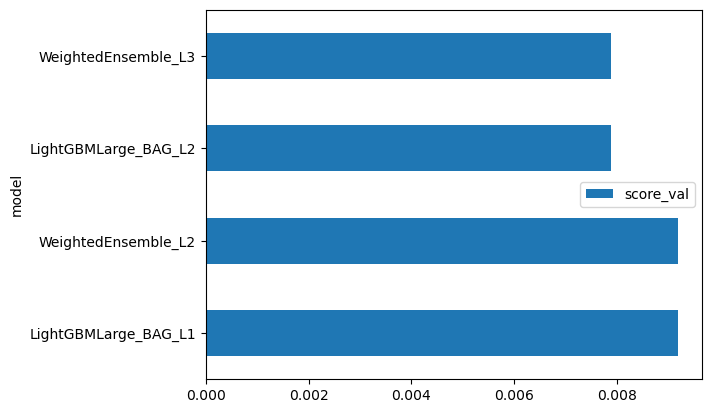

In [ ]:
predictor_new_hpo.leaderboard(silent = True).plot(kind = 'barh',x = 'model',y = 'score_val')

In [ ]:
# Remember to set all negative values to zero
count = predictor_new_hpo.predict(test)
for a,b in enumerate(count):
    if b < 0:
        count[a] = 0

count.describe()

count    6493.000000
mean      384.294163
std       191.006507
min         2.000000
25%       234.000000
50%       365.000000
75%       540.000000
max       884.000000
Name: count, dtype: float64

In [ ]:
# Same submitting predictions
submission_new_hpo = submission.copy()
submission_new_hpo["count"] = count
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 152k/152k [00:00<00:00, 232kB/s]
Successfully submitted to Bike Sharing Demand

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand
#| tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2025-06-16 17:03:30  new features with hyperparameters  complete  1.94330      1.94330       
submission_new_features.csv  2025-06-16 16:44:12  new features                       error                                
submission.csv               2025-06-16 16:21:14  first raw submission hp1           error                                
submission.csv               2025-06-16 16:16:20  first raw submission hp0           complete  1.41005      1.41005       
submission.csv               2025-06-16 16:11:17  first raw submission               complete  2.06498      2.06498       
submission_new_features.csv  2025-06-13 18:32:32  new features                       error                                
submission_new_h

#### New Score of `2.08108`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

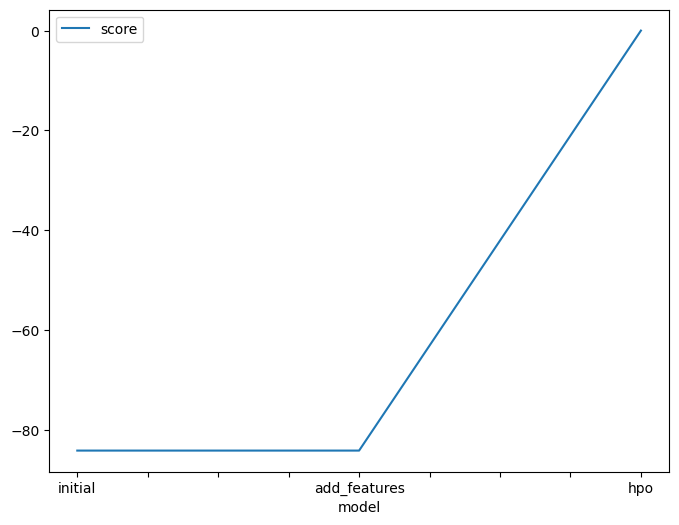

In [ ]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-84.146423, -84.146423,0.004646]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

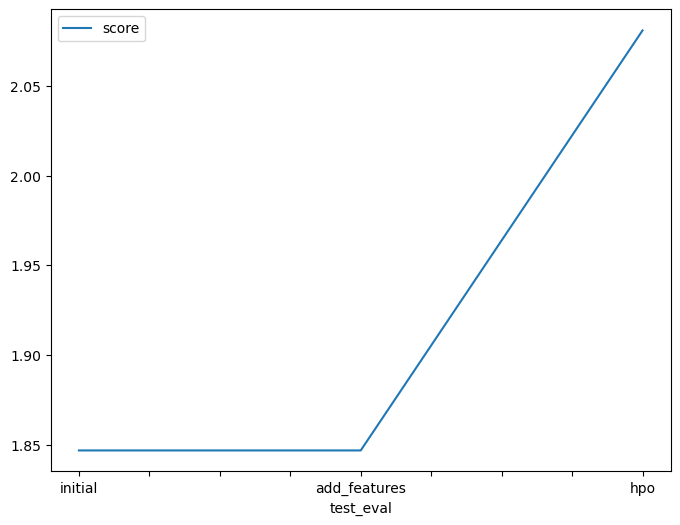

In [ ]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.84672,1.84672, 2.08108]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [ ]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": [-84.146423,-84.146423, -101.588176],
    "hpo2": [-84.146423,-84.146423, -101.588176],
    "hpo3": [0.004646,0.004646,0.004646],
    "score": [1.84672,1.84672, 2.08108]
})


,model,hpo1,hpo2,hpo3,score
0,initial,-84.146423,-84.146423,0.004646,1.84672
1,add_features,-84.146423,-84.146423,0.004646,1.84672
2,hpo,-101.588176,-101.588176,0.004646,2.08108
